In [1]:
#Imports and libraries

import pandas as pd
import numpy as np
from numpy import linalg
import random as rand
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from sklearn import preprocessing
import collections
import math
import statistics

import sys  
sys.path.insert(0, '../scripts')
import krippendorff_alpha
import bootstrap_workers

sys.path.insert(0, '../scripts/xrr')
from xrr.xrr_class import xRR

import warnings
warnings.filterwarnings('ignore')

# Process experiment files and compute stats

In [26]:
#Read the data of the experiment

link1 = '../data/pilot_select_relevant_location_tags.csv'
link2 = '../data/pilot2_select_relevant_location_tags.csv'
link3 = '../data/pilot3_select_relevant_location_tags.csv'

repetition1 = pd.read_csv(link1)
repetition2 = pd.read_csv(link2)
repetition3 = pd.read_csv(link3)

In [27]:
#Get rater ids and the total number of raters per repetition

workerIds1 = list(set(list(repetition1["WorkerId"])))
workerIds2 = list(set(list(repetition2["WorkerId"])))
workerIds3 = list(set(list(repetition3["WorkerId"])))

print("Number of workers in Repetition 1: ", len(workerIds1))
print("Number of workers in Repetition 2: ", len(workerIds2))
print("Number of workers in Repetition 3: ", len(workerIds3))

Number of workers in Repetition 1:  19
Number of workers in Repetition 2:  23
Number of workers in Repetition 3:  21


In [28]:
#Get statistics about the number of judgments

size1 = len(repetition1)
size2 = len(repetition2)
size3 = len(repetition3)

print("Size repetition 1: ", size1)
print("Size repetition 2: ", size2)
print("Size repetition 3: ", size3)

Size repetition 1:  330
Size repetition 2:  330
Size repetition 3:  330


In [29]:
#Process the results of the repetitions

def process_repetitions(repetition, workerIds):
    columns = ["VideoId", "Tag"]
    columns.extend(workerIds)
    columns.extend(['Mean', 'Std', 'NumberWorkers'])

    experiment = pd.DataFrame(columns=columns)

    new_df_index = 0
    for i in range(0, len(repetition), 15):

        for tag in repetition["Input.tags"].iloc[i].split("_###_"):
            row = [repetition["Input.storageLink"].iloc[i], tag]

            for worker in workerIds:

                subset = repetition[(repetition["WorkerId"] == worker) & (repetition["HITId"] == repetition["HITId"].iloc[i])]

                found = -1
                if len(subset) != 0:
                    if tag in subset["Answer.selectedtags_tags"].iloc[0].replace("[", "").replace("]", "").replace('"', "").split(","):
                        found = 1
                    else:
                        found = 0

                else:
                    found = -1

                if found == -1:
                    row.append("")
                if found == 1:
                    row.append(1)
                if found == 0:
                    row.append(0)


            sum_votes = 0
            votes = []
            for elem in row[2:2+len(workerIds)]:
                if elem != "":
                    sum_votes += elem
                    votes.append(elem)
            if sum_votes == 0:
                row.append(0.0)
            else:
                row.append(sum_votes/len(votes)*1.0)
            row.append(statistics.stdev(votes))
            row.append(len(votes))

            experiment.loc[new_df_index] = row
            new_df_index += 1

    #drop duplicates
    experiment = experiment.drop_duplicates(['VideoId','Tag'],keep= 'first')
    
    return experiment

In [30]:
rep1 = process_repetitions(repetition1, workerIds1)
rep2 = process_repetitions(repetition2, workerIds2)
rep3 = process_repetitions(repetition3, workerIds3)

experiment = pd.merge(rep1, rep2, how='left', suffixes=('_x', '_y'), left_on=['VideoId', 'Tag'], right_on=['VideoId','Tag'])
experiment = pd.merge(experiment, rep3, how='left', suffixes=('', '_z'), left_on=['VideoId', 'Tag'], right_on=['VideoId','Tag'])

experiment.head(10)

,VideoId,Tag,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,15,16,17,18,19,20_z,21_z,Mean,Std,NumberWorkers
0,j_70OVLHHPc.mp4,Europe,1,0,0,0,,0,0,0,...,0,0,0,0,,0,0,0.066667,0.258199,15
1,j_70OVLHHPc.mp4,stage,1,1,0,1,,1,1,1,...,1,1,0,1,,1,1,0.733333,0.457738,15
2,j_70OVLHHPc.mp4,auditorium,0,1,0,1,,0,1,1,...,1,0,0,1,,1,1,0.666667,0.487950,15
3,j_70OVLHHPc.mp4,sound stage,0,0,0,1,,1,1,0,...,0,1,0,1,,0,1,0.400000,0.507093,15
4,j_70OVLHHPc.mp4,tourist attraction,0,0,0,0,,0,0,0,...,0,0,1,0,,0,1,0.266667,0.457738,15
5,j_70OVLHHPc.mp4,atmosphere of earth,0,0,0,0,,0,0,0,...,0,0,0,0,,0,0,0.000000,0.000000,15
6,j_70OVLHHPc.mp4,music venue,0,0,0,0,,0,0,0,...,0,0,0,0,,0,0,0.000000,0.000000,15
7,j_70OVLHHPc.mp4,vehicle door,1,0,0,1,,0,0,0,...,0,1,0,1,,0,0,0.466667,0.516398,15
8,j_70OVLHHPc.mp4,theatre,0,1,0,0,,1,0,0,...,0,1,0,1,,1,1,0.533333,0.516398,15
9,j_70OVLHHPc.mp4,nightclub,0,0,0,0,,0,0,0,...,0,0,0,0,,0,0,0.000000,0.000000,15


# Agreement Analysis

In [31]:
#compute Krippendorff's alpha for each experiment
data1 = []
for i in range(2, len(workerIds1)+2):
    data1.append(['*' if x == "" else x for x in list(rep1.iloc[:,i])])

#print(data)
missing = "*"
kappa = krippendorff_alpha.krippendorff_alpha(data1, missing_items=missing)
print("Krippendorff's alpha Repetition 1: ", round(kappa, 4))


data2 = []
for i in range(2, len(workerIds2)+2):
    data2.append(['*' if x == "" else x for x in list(rep2.iloc[:,i])])

#print(data)
missing = "*"
kappa = krippendorff_alpha.krippendorff_alpha(data2, missing_items=missing)
print("Krippendorff's alpha Repetition 2: ", round(kappa, 4))

data3 = []
for i in range(2, len(workerIds3)+2):
    data3.append(['*' if x == "" else x for x in list(rep3.iloc[:,i])])

#print(data)
missing = "*"
kappa = krippendorff_alpha.krippendorff_alpha(data3, missing_items=missing)
print("Krippendorff's alpha Repetition 3: ", round(kappa, 4))

Krippendorff's alpha Repetition 1:  0.3026146785755217
Krippendorff's alpha Repetition 2:  0.3751216469120404
Krippendorff's alpha Repetition 3:  0.33880985774394


# Compute precision analysis on each of the three repetitions

In [32]:
#create new dataframe with details about the tags in the dataset

tags_df = experiment[['VideoId', 'Tag', 'Mean_x', 'Std_x', 'NumberWorkers_x', 'Mean_y', 'Std_y', 'NumberWorkers_y', 'Mean', 'Std', 'NumberWorkers']]
tags_df.to_csv("../data/location_tags_scores_statistics.csv", index=False)

tags_df.head(10)

,VideoId,Tag,Mean_x,Std_x,NumberWorkers_x,Mean_y,Std_y,NumberWorkers_y,Mean,Std,NumberWorkers
0,j_70OVLHHPc.mp4,Europe,0.133333,0.351866,15,0.133333,0.351866,15,0.066667,0.258199,15
1,j_70OVLHHPc.mp4,stage,0.733333,0.457738,15,0.933333,0.258199,15,0.733333,0.457738,15
2,j_70OVLHHPc.mp4,auditorium,0.533333,0.516398,15,0.866667,0.351866,15,0.666667,0.487950,15
3,j_70OVLHHPc.mp4,sound stage,0.400000,0.507093,15,0.666667,0.487950,15,0.400000,0.507093,15
4,j_70OVLHHPc.mp4,tourist attraction,0.133333,0.351866,15,0.066667,0.258199,15,0.266667,0.457738,15
5,j_70OVLHHPc.mp4,atmosphere of earth,0.000000,0.000000,15,0.000000,0.000000,15,0.000000,0.000000,15
6,j_70OVLHHPc.mp4,music venue,0.000000,0.000000,15,0.066667,0.258199,15,0.000000,0.000000,15
7,j_70OVLHHPc.mp4,vehicle door,0.400000,0.507093,15,0.666667,0.487950,15,0.466667,0.516398,15
8,j_70OVLHHPc.mp4,theatre,0.266667,0.457738,15,0.466667,0.516398,15,0.533333,0.516398,15
9,j_70OVLHHPc.mp4,nightclub,0.000000,0.000000,15,0.000000,0.000000,15,0.000000,0.000000,15


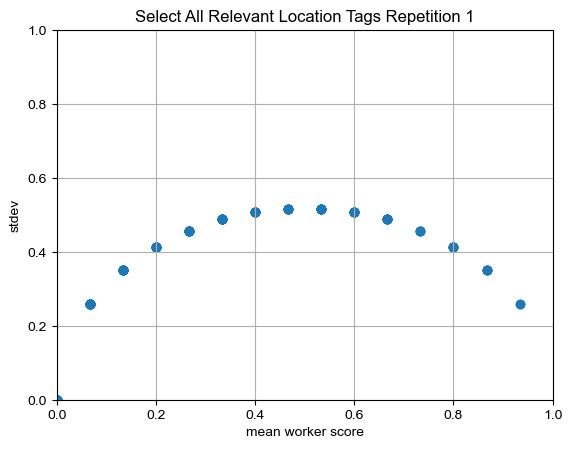

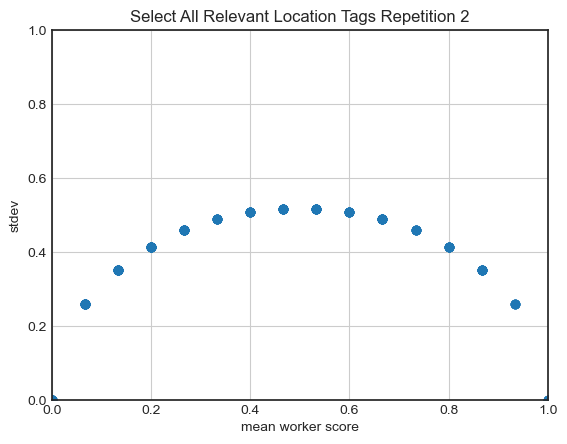

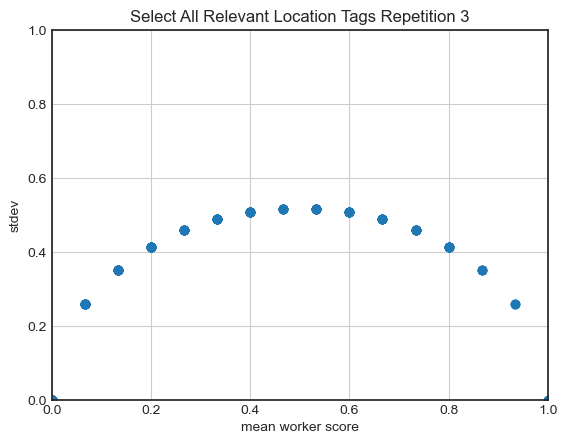

In [33]:
#plot the stdev distributions for the three repetitions
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

def plot_pairs(mean_values, stdev_values, name, xlim=(0,1), ylim=(0,1)):
    f, ax = plt.subplots()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(mean_values, stdev_values)
    plt.style.use('seaborn-white')
    plt.xlabel('mean worker score')
    plt.ylabel('stdev')
    ax.grid(True)
    plt.title(name)
    plt.show()


# plot precision
plot_pairs(list(rep1["Mean"]), list(rep1["Std"]), "Select All Relevant Location Tags Repetition 1")

plot_pairs(list(rep2["Mean"]), list(rep2["Std"]), "Select All Relevant Location Tags Repetition 2")

plot_pairs(list(rep3["Mean"]), list(rep3["Std"]), "Select All Relevant Location Tags Repetition 3")




In [35]:
#compute the mean of standard deviations
exp1_mean_stdev = sum(experiment["Std_x"])/len(experiment["Std_x"])
print("Mean of standard deviations - Repetition 1: ", round(exp1_mean_stdev, 4))

exp2_mean_stdev = sum(experiment["Std_y"])/len(experiment["Std_y"])
print("Mean of standard deviations - Repetition 2: ", round(exp2_mean_stdev, 4))

exp3_mean_stdev = sum(experiment["Std"])/len(experiment["Std"])
print("Mean of standard deviations - Repetition 3: ", round(exp3_mean_stdev, 4))

Mean of standard deviations - Repetition 1:  0.3093
Mean of standard deviations - Repetition 2:  0.3223
Mean of standard deviations - Repetition 3:  0.3118


In [36]:
#compute the standard deviation of deviations
exp1_stdev_stdev = statistics.stdev(experiment["Std_x"])
print("Standard deviation of stdevs - Repetition 1:", round(exp1_stdev_stdev, 4))

exp2_stdev_stdev = statistics.stdev(experiment["Std_y"])
print("standard deviation of stdevs - Repetition 2:", round(exp2_stdev_stdev, 4))

exp3_stdev_stdev = statistics.stdev(experiment["Std"])
print("standard deviation of stdevs - Repetition 3:", round(exp3_stdev_stdev, 4))

Standard deviation of stdevs - Repetition 1: 0.1958
standard deviation of stdevs - Repetition 2: 0.1924
standard deviation of stdevs - Repetition 3: 0.2017


In [37]:
#compute the percentage of tags in [mean-stdev, mean+stdev]
from scipy.stats import spearmanr

rel1 = len(experiment[(experiment["Mean_x"] >= sum(experiment["Std_x"])/len(experiment["Std_x"]) - statistics.stdev(experiment["Std_x"])) & (experiment["Mean_x"] <= sum(experiment["Std_x"])/len(experiment["Std_x"]) + statistics.stdev(experiment["Std_x"]))]) * 100 / len(experiment)
rel2 = len(experiment[(experiment["Mean_y"] >= sum(experiment["Std_y"])/len(experiment["Std_y"])- statistics.stdev(experiment["Std"])) & (experiment["Mean_y"] <= sum(experiment["Std_y"])/len(experiment["Std_y"]) + statistics.stdev(experiment["Std_y"]))]) * 100 / len(experiment)
rel3 = len(experiment[(experiment["Mean"] >= sum(experiment["Std"])/len(experiment["Std"]) - statistics.stdev(experiment["Std"])) & (experiment["Mean"] <= sum(experiment["Std"])/len(experiment["Std"]) + statistics.stdev(experiment["Std"]))]) * 100 / len(experiment)
print("Relevant Locations:", round(rel1, 4), round(rel2, 4), round(rel3, 4))

Relevant Locations: 39.0135 37.2197 39.0135


# Power Analysis

In [44]:
#functions to generate sets of workers per item

def get_uniq_unit_ids(df):
    unique_unit_ids = df["HITId"].unique()
    return unique_unit_ids	

def get_no_work_unit_id(df, unit_id):
    subset_unit_id = df[df["HITId"] == unit_id]
    return (len(subset_unit_id), subset_unit_id)

def count_bits(number, n_bits):
    ret = 0
    bit_pos = []
    for i in range(0, n_bits):
        if (1 << i) & number != 0:
            ret += 1
            bit_pos.append(i)
    return (ret, bit_pos)

def gen_all_k_combinations(k, num_size):
    result = []
    for i in range(1, 2**num_size):
        bit_count, bit_pos = count_bits(i, num_size)
        if bit_count == k:
            result.append(bit_pos)
    return result

def gen_all_worker_combinations(subset_size, count, subset_unit_id):
    combinations = gen_all_k_combinations(subset_size, count)
    final_result = []
    for comb in combinations:
        crnt_workers = []
        for j in range(0, len(comb)):
            crnt_workers.append(subset_unit_id["WorkerId"].iloc[comb[j]])
        final_result.append(crnt_workers)
    return final_result

def get_all_unit_combinations(unit_dict):
    sorted_unit_dict = sorted(unit_dict)
    combinations = it.product(*(unit_dict[unit_id] for unit_id in sorted_unit_dict))


def my_product(dicts):
    units, comb_of_workers = zip(*dicts.items())
    return [dict(zip(units, x)) for x in it.product(*comb_of_workers)]

def pick_random_worker_set(worker_sets):
    return random.choice(worker_sets)



In [ ]:
#Bootstrap experiments - experiment with the number of raters per item


def bootstrap_experiments(repetition, repetitionId)
    unique_unit_ids = get_uniq_unit_ids(repetition)

    alpha_values = {}
    mean_values = {}
    stdev_values = {}
    variance_values = {}

    columns_df = ["No Workers"]
    columns_df.extend(["Run %s" % i for i in range(1,101)])
    columns_df.extend(["Mean", "Stdev", "Variance", "Median", "Min", "Max"])

    with open('../data/bootstrap_workers_IRR_VCR_L_' + repetitionId + '.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(columns_df)

    df_study = []

    for subset_size in range(3, 15):   
        row_df = [subset_size]
        map_unit_id_combinations = {}
        alpha_values[subset_size] = []
        mean_values[subset_size] = {}
        stdev_values[subset_size] = {}
        variance_values[subset_size] = {}

        for unit_id in range(0, len(unique_unit_ids)):
            (count, subset_unit_id) = get_no_work_unit_id(select_all_round1, unique_unit_ids[unit_id])
            combinations = gen_all_worker_combinations(subset_size, count, subset_unit_id)

            map_unit_id_combinations[unique_unit_ids[unit_id]] = combinations

        for run_no in range(0, 100):
            videoIds = []
            videoTags = []
            unit_worker_set = {}
            for c_unit_id, c_worker_sets in map_unit_id_combinations.items():
                unit_worker_set[c_unit_id] = pick_random_worker_set(c_worker_sets)

            df_subset_size = pd.DataFrame()

            for current_unit_id, current_worker_set in unit_worker_set.items():
                df_subset = select_all_round1[(select_all_round1["HITId"] == current_unit_id) & (select_all_round1["WorkerId"].isin(current_worker_set))]
                frames = [df_subset_size, df_subset]
                df_subset_size = pd.concat(frames) 

            subset_workers = list(set(df_subset_size["WorkerId"]))
            columns = ["VideoId", "Tag"]
            columns.extend(subset_workers)
            columns.extend(['Mean', 'Std', 'NumberWorkers'])

            experiment_workers = pd.DataFrame(columns=columns)
            new_df_index = 0

            for i in range(0, len(df_subset_size), subset_size):      
                for tag in df_subset_size["Input.tags"].iloc[i].split("_###_"):
                    row = [df_subset_size["Input.storageLink"].iloc[i], tag]
                    videoIds.append(df_subset_size["Input.storageLink"].iloc[i])
                    videoTags.append(tag)
                    

                    for worker in subset_workers:

                        subset = df_subset_size[(df_subset_size["WorkerId"] == worker) & (df_subset_size["HITId"] == df_subset_size["HITId"].iloc[i])]

                        found = -1
                        if len(subset) != 0:
                            if tag in subset["Answer.selectedtags_tags"].iloc[0].replace("[", "").replace("]", "").replace('"', "").split(","):
                                found = 1
                            else:
                                found = 0         
                        else:
                            found = -1

                        if found == -1:
                            row.append("")
                        if found == 1:
                            row.append(1)
                        if found == 0:
                            row.append(0)


                    sum_votes = 0
                    votes = []
                    for elem in row[2:2+len(subset_workers)]:
                        if elem != "":
                            sum_votes += elem
                            votes.append(elem)
                    if sum_votes == 0:
                        row.append(0.0)
                    else:
                        row.append(sum_votes/len(votes)*1.0)
                    row.append(statistics.stdev(votes))
                    row.append(len(votes))

                    if df_subset_size["Input.storageLink"].iloc[i] + " - " + tag not in mean_values[subset_size]:
                        mean_values[subset_size][df_subset_size["Input.storageLink"].iloc[i] + " - " + tag] = [sum_votes/len(votes)*1.0]
                        stdev_values[subset_size][df_subset_size["Input.storageLink"].iloc[i] + " - " + tag] = [statistics.stdev(votes)]
                        variance_values[subset_size][df_subset_size["Input.storageLink"].iloc[i] + " - " + tag] = [statistics.variance(votes)]
                    else:
                        mean_values[subset_size][df_subset_size["Input.storageLink"].iloc[i] + " - " + tag].append(sum_votes/len(votes)*1.0)
                        stdev_values[subset_size][df_subset_size["Input.storageLink"].iloc[i] + " - " + tag].append(statistics.stdev(votes))
                        variance_values[subset_size][df_subset_size["Input.storageLink"].iloc[i] + " - " + tag].append(statistics.variance(votes))

                    experiment_workers.loc[new_df_index] = row
                    new_df_index += 1

                experiment_workers = experiment_workers.drop_duplicates(['VideoId','Tag'],keep= 'first')

                data = []
                for i in range(2, len(subset_workers)+2):
                    data.append(['*' if x == "" else x for x in list(experiment_workers.iloc[:,i])])

                missing = "*"
                kappa = krippendorff_alpha(data, missing_items=missing)
                row_df.append(kappa)
                alpha_values[subset_size].append(kappa)

        row_df.append(sum(alpha_values[subset_size])/len(alpha_values[subset_size]))
        row_df.append(statistics.stdev(alpha_values[subset_size]))
        row_df.append(statistics.variance(alpha_values[subset_size]))
        row_df.append(statistics.median(alpha_values[subset_size]))
        row_df.append(min(alpha_values[subset_size]))
        row_df.append(max(alpha_values[subset_size]))   
        df_study.append(row_df) 

        with open('../data/bootstrap_workers_IRR_VCR_L_' + repetitionId + '.csv','a') as f:
            writer = csv.writer(f)
            writer.writerow(row_df)
            
#uncomment these lines if you want to run the cell
#bootstrap_experiments(repetition1, 'rep1')
#bootstrap_experiments(repetition2, 'rep2')
#bootstrap_experiments(repetition3, 'rep3')

In [45]:
#chi-square test for the variance (H0: sigma < sigma_0)

#H0: sigma >= 0.01
#Ha: sigma < 0.01
# large values of chi square give us evidence against the null hypothesis
link1 = '../data/bootstrap_workers_IRR_VCR_L_rep1.csv'
link2 = '../data/bootstrap_workers_IRR_VCR_L_rep2.csv'
link3 = '../data/bootstrap_workers_IRR_VCR_L_rep3.csv'

bootstrap1 = pd.read_csv(link1)
bootstrap2 = pd.read_csv(link2)
bootstrap3 = pd.read_csv(link3)

def power_analysis(repetition):
    for i in range(len(repetition)):

        N = 100 #numnber of samples
        values = repetition.iloc[i,1:101]
        s = statistics.stdev(values) 
        delta = 0.01

        chi_square = (N - 1) * s * s / (delta * delta)
        dof = N - 1
        alpha = 0.05

        from scipy.stats import chi2
        p_value = 1 - stats.chi2.cdf(chi_square, dof)

        if p_value >= alpha:
            print("reject the null hypothesis for ", repetition["No Workers"].iloc[i], p_value)
        else:
            print("do not reject the null hypothesis for", repetition["No Workers"].iloc[i], p_value)



In [46]:
print("\nRepetition 1:")
power_analysis(bootstrap1)

print("\nRepetition 2:")
power_analysis(bootstrap2)

print("\nRepetition 3:")
power_analysis(bootstrap3)


Repetition 1:
do not reject the null hypothesis for 2 0.0
do not reject the null hypothesis for 3 0.0
do not reject the null hypothesis for 4 0.0
do not reject the null hypothesis for 5 0.0
do not reject the null hypothesis for 6 0.0
do not reject the null hypothesis for 7 0.0
do not reject the null hypothesis for 8 0.0
do not reject the null hypothesis for 9 0.009689663898738266
do not reject the null hypothesis for 10 0.01329786862583704
reject the null hypothesis for  11 0.6711915376767683
reject the null hypothesis for  12 0.9879931112955121
reject the null hypothesis for  13 0.9999999898953179
reject the null hypothesis for  14 1.0

Repetition 2:
do not reject the null hypothesis for 3 0.0
do not reject the null hypothesis for 4 0.0
do not reject the null hypothesis for 5 0.0
do not reject the null hypothesis for 6 0.0
do not reject the null hypothesis for 7 0.0
do not reject the null hypothesis for 8 2.55351295663786e-15
do not reject the null hypothesis for 9 3.910432977427547e

# Stability Analysis

In [38]:
#compute the Spearman's rank correlation 
from scipy.stats import spearmanr

rho, pval = spearmanr(experiment["Mean_x"], experiment["Mean_y"], axis=1)
print("Spearman Correlation between Repetition 1 & Repetition 2:", round(rho, 4), round(pval, 4))

rho, pval = spearmanr(experiment["Mean_x"], experiment["Mean"], axis=1)
print("Spearman Correlation between Repetition 1 & Repetition 3:", round(rho, 4), round(pval, 4))

rho, pval = spearmanr(experiment["Mean_y"], experiment["Mean"], axis=1)
print("Spearman Correlation between Repetition 2 & Repetition 3:", round(rho, 4), round(pval, 4))


Spearman Correlation between Repetition 1 & Repetition 2: 0.9086 0.0
Spearman Correlation between Repetition 1 & Repetition 3: 0.8895 0.0
Spearman Correlation between Repetition 2 & Repetition 3: 0.9092 0.0


In [39]:
#compute the correlation of standard deviations - Pearson correlation
from scipy.stats import pearsonr

rho, pval = pearsonr(experiment["Std_x"], experiment["Std_y"])
print("Pearson correlation between Repetition 1 & Repetition 2: ", round(rho, 4), round(pval, 4))

rho, pval = pearsonr(experiment["Std_x"], experiment["Std"])
print("Pearson correlation between Repetition 1 & Repetition 3: ", round(rho, 4), round(pval, 4))

rho, pval = pearsonr(experiment["Std_y"], experiment["Std"])
print("Pearson correlation between Repetition 2 & Repetition 3: ", round(rho, 4), round(pval, 4))

Pearson correlation between Repetition 1 & Repetition 2:  0.7148 0.0
Pearson correlation between Repetition 1 & Repetition 3:  0.7525 0.0
Pearson correlation between Repetition 2 & Repetition 3:  0.7428 0.0


# Replicability Similarity Analysis

In [40]:
# prepare data to apply xRR analysis
# concatenate results of all three repetitions
columns = ["ItemIndex", "Item", "Repetition", "Rater", "RaterIndex", "Relevance"]

dictItems = {}
dictRaters = {}

indexItems = 1
for i in range(len(rep1)):
    dictItems[rep1["VideoId"].iloc[i] + "-" + rep1["Tag"].iloc[i]] = indexItems
    indexItems += 1

indexRaters = 1
allworkers = list(set(list(rep1.columns[2:-4]) + list(rep2.columns[2:-4]) + list(rep3.columns[2:-4])))
for worker in allworkers:
    dictRaters[worker] = indexRaters
    indexRaters += 1

def create_df_xrr(rep, workers, rows, repetitionId):
    for i in range(len(rep)):
        for worker in workers:
            if rep[worker].iloc[i] == 0:
                row = [dictItems[rep["VideoId"].iloc[i] + "-" + rep["Tag"].iloc[i]], rep["VideoId"].iloc[i] + "-" + rep["Tag"].iloc[i], repetitionId, dictRaters[worker], worker, 0]
                rows.append(row)
            if rep[worker].iloc[i] == 1:
                row = [dictItems[rep["VideoId"].iloc[i] + "-" + rep["Tag"].iloc[i]], rep["VideoId"].iloc[i] + "-" + rep["Tag"].iloc[i], repetitionId, dictRaters[worker], worker, 1]
                rows.append(row)
                
    return rows

rows = []
workers = rep1.columns[2:-4]
rows = create_df_xrr(rep1, workers, rows, "Repetition 1")

workers = rep2.columns[2:-4]
rows = create_df_xrr(rep2, workers, rows, "Repetition 2")

workers = rep3.columns[2:-4]
rows = create_df_xrr(rep3, workers, rows, "Repetition 3")

xrr_df = pd.DataFrame.from_records(rows)
xrr_df.columns = columns

xrr_df.to_csv("../data/xrr_relevant_locations.csv", index=False)

In [43]:
data_full_r1 = xrr_df[xrr_df.Repetition == "Repetition 1"]
data_full_r2 = xrr_df[xrr_df.Repetition == "Repetition 2"]
data_full_r3 = xrr_df[xrr_df.Repetition == "Repetition 3"]

xRR_matrix = np.ones((3, 3), dtype = float)

xRR_object_12 = xRR(data_full_r1, data_full_r2, "Relevance", "Rater", "ItemIndex")
xRR_matrix[1, 0] = round(xRR_object_12.kappa_x(), 4)
xRR_object_13 = xRR(data_full_r1, data_full_r3, "Relevance", "Rater", "ItemIndex")
xRR_matrix[2, 0] = round(xRR_object_13.kappa_x(), 4)
xRR_object_23 = xRR(data_full_r2, data_full_r3, "Relevance", "Rater", "ItemIndex")
xRR_matrix[2, 1] = round(xRR_object_23.kappa_x(), 4)

print("xRR score between Repetition 1 and Repetition 2 raters:", round(xRR_object_12.kappa_x(), 4))
print("xRR score between Repetition 1 and Repetition 3 raters:", round(xRR_object_13.kappa_x(), 4))
print("xRR score between Repetition 2 and Repetition 3 raters:", round(xRR_object_23.kappa_x(), 4))

xRR_matrix

22/08/2023 16:17:29  observed disagreement: 0.2812606789985886
22/08/2023 16:17:30  expected disagreement: 0.42526284375106227
22/08/2023 16:17:30  observed disagreement: 0.2697219843831185
22/08/2023 16:17:30  expected disagreement: 0.39999452039781913
22/08/2023 16:17:31  observed disagreement: 0.27991663111889414
22/08/2023 16:17:31  expected disagreement: 0.43626332687391484


xRR score between Repetition 1 and Repetition 2 raters: 0.3386
xRR score between Repetition 1 and Repetition 3 raters: 0.3257
xRR score between Repetition 2 and Repetition 3 raters: 0.3584


array([[1.    , 1.    , 1.    ],
       [0.3386, 1.    , 1.    ],
       [0.3257, 0.3584, 1.    ]])

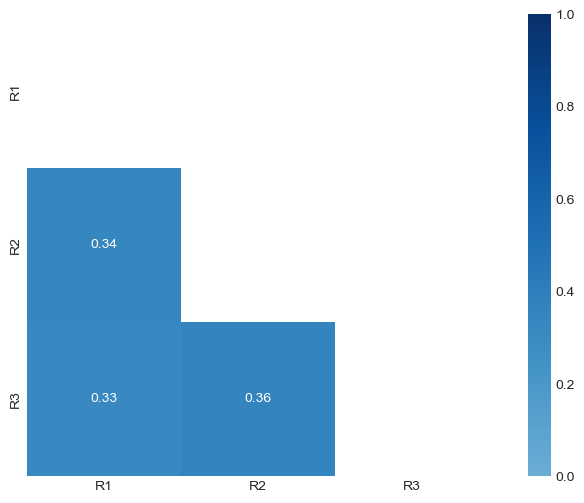

In [42]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

columns = ["R1", "R2", "R3"]
df_data = pd.DataFrame(xRR_matrix, columns = columns)

# Create a mask
mask = np.triu(np.ones_like(df_data, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(df_data, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap="Blues", yticklabels=["R1", "R2", "R3"],
            vmin=0.0, vmax=1.0)
plt.savefig("../plots/xRR_VCR_L.png",  bbox_inches='tight', format='png', dpi=1200)
plt.show()